In [6]:
%cd /home/jupyter/kaggleDeepFakeDetection

from pathlib import Path
import fastai
from fastai.callbacks import SaveModelCallback
from fastai.vision import ImageList, cnn_learner, models, error_rate, accuracy, ShowGraph, ItemList, ImageDataBunch
from torch.nn.functional import cross_entropy
import config

import pandas as pd
from services import file_service

logger = config.create_logger(__name__)

image_path = Path(config.OUTPUT_PATH_C, 'image_splitting', 'dataobjects')

logger.info(f'image_path: {image_path}')

data = ImageDataBunch.from_folder(path=image_path, bs=32)

/home/jupyter/kaggleDeepFakeDetection
2020-04-08 00:39:57,583 - __main__ - INFO - image_path: /home/jupyter/f22data/output/image_splitting/dataobjects


In [8]:
model = models.resnet50

fastai.torch_core.defaults.device = 'gpu'
    
learn = cnn_learner(data, model, metrics=[cross_entropy, accuracy])

best_weights_path = Path(config.OUTPUT_MODEL_PAR_PATH, 'cnn_resnet50_2020-04-07T03-12-16-968388.pkl_2')
learn.load(best_weights_path)

Learner(data=ImageDataBunch;

Train: LabelList (1104223 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/f22data/output/image_splitting/dataobjects;

Valid: LabelList (295519 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/f22data/output/image_splitting/dataobjects;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

epoch,train_loss,valid_loss,cross_entropy,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Learner(data=ImageDataBunch;

Train: LabelList (1104223 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/f22data/output/image_splitting/dataobjects;

Valid: LabelList (295519 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/f22data/output/image_splitting/dataobjects;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

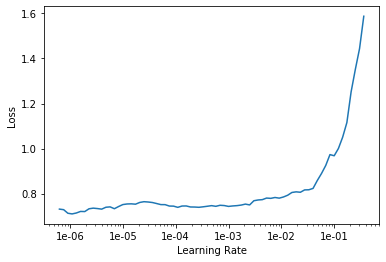

In [9]:
learn.save('before-learner')
learn.lr_find()
learn.recorder.plot()
learn.load('before-learner')
# 3e-06,4e-06

In [ ]:
from fastai.callbacks import EarlyStoppingCallback
from fastai.vision import partial

file_path = file_service.get_unique_persist_filename(config.OUTPUT_MODEL_PAR_PATH, base_output_stem=f'cnn_{model.__qualname__}', extension='pkl', use_date=True)

learn.fit_one_cycle(50, slice(3e-05,1e-04), callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='improvement',  
                  monitor='cross_entropy', name=file_path)])

epoch,train_loss,valid_loss,cross_entropy,accuracy,time


In [9]:
pickle_par_path = Path(config.OUTPUT_MODEL_PAR_PATH, 'data')
pickle_par_path.mkdir(exist_ok=True)

# df.to_pickle(Path(pickle_par_path, 'df'))
# df_train.to_pickle(Path(pickle_par_path, 'df_train'))
# df_val.to_pickle(Path(pickle_par_path, 'df_val'))
# df_test.to_pickle(Path(pickle_par_path, 'df_test'))


In [11]:
data.path = pickle_par_path

data.save()

learn_par_path = Path(config.OUTPUT_MODEL_PAR_PATH, 'learners')
learn_par_path.mkdir(exist_ok=True)
learn_path = Path(learn_par_path, 'cnn_learner.pkl')

learn.export(learn_path)

epoch,train_loss,valid_loss,cross_entropy,accuracy,time
0,0.556485,0.566800,0.566800,0.704390,27:16
1,0.551780,0.556969,0.556969,0.713008,26:46
2,0.558862,0.563114,0.563113,0.703630,26:47
3,0.563919,0.559598,0.559598,0.710067,26:32
4,0.558623,0.583793,0.583793,0.691286,26:44
5,0.553031,0.586411,0.586411,0.694175,26:36
6,0.565860,0.569053,0.569054,0.700512,26:38
7,0.561030,0.568358,0.568358,0.706950,26:32
8,0.551098,0.594631,0.594631,0.687636,26:38
9,0.541232,0.552316,0.552316,0.713616,26:46


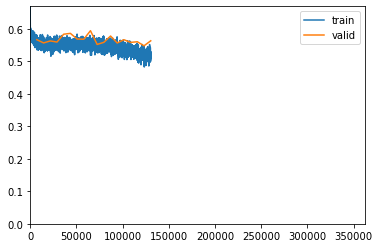

RuntimeError: Caught RuntimeError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\fastai\torch_core.py", line 127, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\utils\data\_utils\collate.py", line 53, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "c:\programdata\miniconda3\envs\kaggledeepfakedetection\lib\site-packages\torch\storage.py", line 128, in _new_shared
    return cls._new_using_filename(size)
RuntimeError: Couldn't open shared file mapping: <torch_18628_3606851850>, error code: <1455>


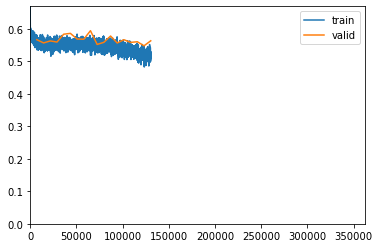

In [12]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(1e-03,3e-03), callbacks=[ShowGraph(learn), SaveModelCallback(learn, every='epoch',  
                  monitor='cross_entropy', name=file_path)])